In [1]:

import hashlib
import os
import random
import time
from datetime import datetime
from io import BytesIO

import pandas as pd
import praw
import requests
import torch
from PIL import Image
from dask.diagnostics import ProgressBar
from pmaw import PushshiftAPI
from tqdm import tqdm

from shared_code.utility.schemas.pyarrow_schema import schema
from shared_code.utility.spark.set_environ import set_azure_env

set_azure_env()

from shared_code.utility.storage.azure_file_storage import AzureFileStorageAdapter
from shared_code.utility.scripts.blip_caption import BlipCaption

pbar = ProgressBar()
pbar.register()

tqdm.pandas()
tqdm.pandas(desc="global")

from tqdm.dask import TqdmCallback

cb = TqdmCallback(desc="global")
cb.register()

file_system = AzureFileStorageAdapter('data').get_file_storage()

In [2]:
%%time

subs = [
	"SFWRedheads",
	"sfwpetite",
	"SFWNextDoorGirls",
	"trippinthroughtime",
	"fatsquirrelhate",
	"itookapicture",
	"memes",
	"WhitePeopleTwitter",
	"CityPorn",
	"EarthPorn",
	"spaceporn",
	"realasians",
	"KoreanHotties",
	"prettyasiangirls",
	"AsianOfficeLady",
	"mildlypenis"
]


CPU times: total: 0 ns
Wall time: 0 ns


In [3]:
%%time

extant_data = pd.read_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system, schema=schema)
display(extant_data)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,128z5ns,celebrities,A-Sexy-Name,Rachel Weisz,cars are parked on the side of the road in the...,f09b1c0c5dea50c934081a04c83d4d33,/r/celebrities/comments/128z5ns/rachel_weisz/,https://i.redd.it/nv80afddacra1.jpg,f09b1c0c5dea50c934081a04c83d4d33.jpg,D:\data\images\celebrities\f09b1c0c5dea50c9340...,D:\data\images\celebrities\thumbnail\f09b1c0c5...,True,False
1,11yk8db,prettyasiangirls,MisoShiru520,Library,blonde woman with blonde hair and tattoos on h...,9d5b7331b941ecf3fdbc8ad322303825,/r/prettyasiangirls/comments/11yk8db/library/,https://i.redd.it/ht4d2wuusapa1.jpg,9d5b7331b941ecf3fdbc8ad322303825.jpg,D:\data\images\prettyasiangirls\9d5b7331b941ec...,D:\data\images\prettyasiangirls\thumbnail\9d5b...,True,False
2,11hfioi,KoreanHotties,Majestic_Painter8660,Underboob bikini,a man with a beard and a beard sitting in fron...,a154a56b1b87cf3a0bc93600c86e4585,/r/KoreanHotties/comments/11hfioi/underboob_bi...,https://i.redd.it/cimr17q84jla1.jpg,a154a56b1b87cf3a0bc93600c86e4585.jpg,D:\ImageDoesNotExist.png,D:\data\images\KoreanHotties\thumbnail\a154a56...,False,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,D:\data\images\spaceporn\7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,D:\data\images\spaceporn\abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32087,12vowq9,EarthPorn,jcbeedie98,"Lush Rainforest Creek, West Vancouver, BC Cana...",there is a stream running through a forest fil...,6ec7bd503710da136ca82ff485fe72b5,/r/EarthPorn/comments/12vowq9/lush_rainforest_...,https://i.redd.it/5u71xc561jva1.jpg,6ec7bd503710da136ca82ff485fe72b5.jpg,D:\data\images\EarthPorn\6ec7bd503710da136ca82...,None,True,False
32088,12w3gmx,spaceporn,HeStoleMyBalloons,The launch of a Delta IV Heavy with the final ...,arafed rocket with a large stack of smoke comi...,d5b667054f921f849f39ff012880e8a7,/r/spaceporn/comments/12w3gmx/the_launch_of_a_...,https://i.redd.it/osgmavytxlva1.jpg,d5b667054f921f849f39ff012880e8a7.jpg,D:\data\images\spaceporn\d5b667054f921f849f39f...,None,True,False
32089,12w9hob,KoreanHotties,LoLsupportsmurf,Everyday Korean Girl,there is a woman in a black bra top sitting in...,9425210986f60470764cbe3fc1033a86,/r/KoreanHotties/comments/12w9hob/everyday_kor...,https://i.redd.it/hbuwlnw0lova1.jpg,9425210986f60470764cbe3fc1033a86.jpg,D:\data\images\KoreanHotties\9425210986f604707...,None,True,False
32090,12w9n5p,AsianOfficeLady,King_Oppai,#1249,arafed woman in a pink suit leaning against a ...,5143eea90b793fbb711ab3c6dd5a77d4,/r/AsianOfficeLady/comments/12w9n5p/1249/,https://i.redd.it/cyiotf2f4nva1.jpg,5143eea90b793fbb711ab3c6dd5a77d4.jpg,D:\data\images\AsianOfficeLady\5143eea90b793fb...,None,True,False


CPU times: total: 234 ms
Wall time: 883 ms


In [4]:
reddit: praw.Reddit = praw.Reddit(client_id='5hVavL0PIRyM_1JSvqT6UQ', client_secret='BjD2kS3WNLnJc59RKY-JJUuc_Z9-JA', user_agent='script:%(bot_name)s:v%(bot_version)s (by /u/%(bot_author)s)')

api: PushshiftAPI = PushshiftAPI(praw=reddit, num_workers=12)

Version 7.6.1 of praw is outdated. Version 7.7.0 was released Saturday February 25, 2023.


In [5]:
from dask.callbacks import Callback
from tqdm.autonotebook import tqdm


class TQDMDaskProgressBar(Callback, object):
    """
    A tqdm progress bar for dask.
    Usage:
        ```
        with TQDMDaskProgressBar():
            da.compute()
        ```
    Author : wassname
    Source : https://gist.github.com/wassname/1837d0365247430e02abda41f0e7f184
    See: http://dask.pydata.org/en/latest/diagnostics-local.html?highlight=progress
    """

    def __init__(self, start=None, start_state=None, pretask=None, posttask=None, finish=None, **kwargs):
        super(TQDMDaskProgressBar, self).__init__(
            start=start,
            start_state=start_state,
            pretask=pretask,
            posttask=posttask,
            finish=finish,
        )
        self.tqdm_args = kwargs
        self.states = ["ready", "waiting", "running", "finished"]

    def _start_state(self, dsk, state):
        self._tqdm = tqdm(total=sum(len(state[k]) for k in self.states), **self.tqdm_args)

    def _posttask(self, key, result, dsk, state, worker_id):
        self._tqdm.update(1)

    def _finish(self, dsk, state, errored):
        self._tqdm.close()

In [6]:
def filter_by_image_post(item) -> bool:
	return not (item['selftext'].__contains__('[removed]') or item['selftext'].__contains__('[deleted]') and not item[
		'url'].endswith('.jpg'))

In [7]:
def fetch_image(x: object) -> object:
	try:
		time.sleep(0.1)
		url = x['original_url']
		subreddit = x['subreddit']
		response = requests.get(url)
		md5 = hashlib.md5(response.content).hexdigest()
		os.makedirs(f"D:\\data\\images\\{subreddit}", exist_ok=True)
		out_path = f"D:\\data\\images\\{subreddit}\\{md5}.jpg"

		if os.path.exists(out_path):
			return out_path

		if md5 in list(extant_data['hash']):
			return out_path

		if md5 != "f17b01901c752c1bb04928131d1661af" or md5 != "d835884373f4d6c8f24742ceabe74946":
			raw_image = Image.open(BytesIO(response.content))
			raw_image.save(out_path)
			raw_image.close()
			return out_path
		else:
			return ""
	except Exception as e:
		print(e)
		return ""

In [8]:
def exists(x: object) -> bool:
	try:
		image_path = os.path.exists(x['path'])
		return image_path
	except Exception as e:
		print(e)
		return False

In [9]:
def split_hash(x: object) -> str:
	try:
		name = x['image_name']
		return name.split('.')[0]
	except Exception as e:
		print(e)
		return ""

In [10]:
def caption_image(x: object, blip_captioning_list: [BlipCaption, BlipCaption]) -> str:
	try:
		path = x['path']
		exists_image = bool(x['exists'])
		resulting_caption = x['caption']

		if not os.path.exists(path):
			return ""

		if not exists_image:
			return ""

		if resulting_caption == None:
			pass
		if resulting_caption is None:
			pass
		else:
			if len(resulting_caption) > 5:
				return resulting_caption
			if resulting_caption != "":
				return resulting_caption
			else:
				pass

		blip_captioning = random.choice(blip_captioning_list)

		resulting_caption = blip_captioning.caption_image(path)

		return resulting_caption

	except Exception as e:
		print(e)
		return ""
	finally:
		pass

In [11]:
def get_image_name(x: object) -> str:
	try:
		path = x['path']
		if path == "":
			return ""
		return os.path.basename(path)
	except Exception as e:
		print(e)
		return ""

In [12]:
# #@title Calculate Time Intervals For Training
#
# start_date = "2023-04-08"
# end_date = datetime.today().timestamp()
# day_in_seconds = 86400
#
# start_date_time_stamp: int = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp() - day_in_seconds * 3)
#
# end_date_time_stamp: int = int(end_date)
#
# total_number_days_since_start = (end_date_time_stamp - start_date_time_stamp) # // day_in_seconds
#
# temp = start_date_time_stamp
#
# intervals = []
# while temp < end_date_time_stamp:
# 	temp = temp + day_in_seconds
# 	intervals.append(temp)
#
# print(f"Total Number Of Intervals: {len(intervals)}\n")

Total Number Of Intervals: 19



In [13]:
from praw.models import ListingGenerator
import pandas as pd

posts = []
for sub in subs:
	existing_data = pd.read_parquet(f"{sub}")
	try:
		subreddit_stream: ListingGenerator = reddit.subreddit(display_name=sub).top(limit=100, time_filter='day')
		subreddit_stream = list(subreddit_stream)
		for submission in tqdm(subreddit_stream, total=len(subreddit_stream), desc=f"Posts - {sub}"):
			if submission is None:
				continue
			if not os.path.exists(f"{sub}"):
				os.makedirs(f"{sub}")
			else:
				if submission.id in list(extant_data['id']):
					continue
			try:
				author_name = 'Unknown'
				subreddit_name = sub
				try:
					author_name = submission.author.name
				except Exception as e:
					print(e)
					pass
				p = {
					'id': submission.id,
					'subreddit': subreddit_name,
					'author': author_name,
					'title': submission.title,
					'caption': '',
					'hash': '',
					'permalink': submission.permalink,
					'original_url': submission.url,
					'image_name': '',
					'path': '',
					'thumbnail_path': '',
					'exists': False,
					'curated': False
				}
				pd.DataFrame([p]).to_parquet(f"{sub}/{submission.id}.parquet")
			except Exception as e:
				print(e)
				continue
	except Exception as e:
		print(e)
		continue

	dfs = [ pd.read_parquet(f"{sub}/{item}") for item in os.listdir(f"{sub}") if item.endswith(".parquet") ]
	f = pd.concat(dfs)
	sub_posts = f.to_dict(orient='records')
	posts.extend(sub_posts)

all_data = pd.DataFrame(data=posts)
display(all_data)

Posts - SFWRedheads:   0%|          | 0/58 [00:00<?, ?it/s]

Posts - sfwpetite:   0%|          | 0/4 [00:00<?, ?it/s]

Posts - SFWNextDoorGirls:   0%|          | 0/86 [00:00<?, ?it/s]

Posts - trippinthroughtime:   0%|          | 0/2 [00:00<?, ?it/s]

Posts - fatsquirrelhate:   0%|          | 0/17 [00:00<?, ?it/s]

Posts - oldladiesbakingpies: 0it [00:00, ?it/s]

Posts - itookapicture:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - memes:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - WhitePeopleTwitter:   0%|          | 0/100 [00:00<?, ?it/s]

Posts - CityPorn:   0%|          | 0/52 [00:00<?, ?it/s]

Posts - EarthPorn:   0%|          | 0/44 [00:00<?, ?it/s]

Posts - spaceporn:   0%|          | 0/13 [00:00<?, ?it/s]

Posts - realasians:   0%|          | 0/65 [00:00<?, ?it/s]

Posts - KoreanHotties:   0%|          | 0/8 [00:00<?, ?it/s]

Posts - prettyasiangirls:   0%|          | 0/18 [00:00<?, ?it/s]

Posts - AsianOfficeLady:   0%|          | 0/2 [00:00<?, ?it/s]

Posts - mildlypenis:   0%|          | 0/39 [00:00<?, ?it/s]

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,12ob8sz,SFWRedheads,goneh0t,Just saying hi 👋whilst I'm having a good day,,,/r/SFWRedheads/comments/12ob8sz/just_saying_hi...,https://i.redd.it/5pf8465ad9ua1.jpg,,,,False,False
1,12obxk2,SFWRedheads,crystalcolette,"Yes, I'm a natural redhead",,,/r/SFWRedheads/comments/12obxk2/yes_im_a_natur...,https://i.redd.it/61yzmr72yaua1.png,,,,False,False
2,12oe9ra,SFWRedheads,Free_Range_Ginger,Spending the day like this 😏,,,/r/SFWRedheads/comments/12oe9ra/spending_the_d...,https://i.redd.it/r0rn6pnr6bua1.jpg,,,,False,False
3,12ognj6,SFWRedheads,Puzzled_MJ,How’s your day going?,,,/r/SFWRedheads/comments/12ognj6/hows_your_day_...,https://i.redd.it/dc07dgwigbua1.jpg,,,,False,False
4,12oh9ne,SFWRedheads,KittyKidKill,Just one of those days where you don't get dre...,,,/r/SFWRedheads/comments/12oh9ne/just_one_of_th...,https://i.redd.it/iz1q5gmxjbua1.png,,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,12wchvk,mildlypenis,skrattarforlorar510,these hairs in my shower,,,/r/mildlypenis/comments/12wchvk/these_hairs_in...,https://i.redd.it/t2mekfgyvova1.jpg,,,,False,False
1976,12wcpqj,mildlypenis,sunspot5b,My husband was calibrating his 3D printer and...,,,/r/mildlypenis/comments/12wcpqj/my_husband_was...,https://i.imgur.com/l6DWUSE.jpg,,,,False,False
1977,12webvb,mildlypenis,serenity_later,The inside of my padded bike shorts,,,/r/mildlypenis/comments/12webvb/the_inside_of_...,https://i.imgur.com/RgSARo8.jpg,,,,False,False
1978,12wecrk,mildlypenis,Weird_Succotash8643,Peppa pig bread,,,/r/mildlypenis/comments/12wecrk/peppa_pig_bread/,https://i.redd.it/o6rebenzymva1.jpg,,,,False,False


In [14]:
%%time

# dfs = []
# for sub in subs:
# 	dfs.extend( [ pd.read_parquet(f"{sub}/{item}") for item in os.listdir(f"{sub}") if item.endswith(".parquet") ])

df = all_data #pd.concat(dfs)
display(df)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,12ob8sz,SFWRedheads,goneh0t,Just saying hi 👋whilst I'm having a good day,,,/r/SFWRedheads/comments/12ob8sz/just_saying_hi...,https://i.redd.it/5pf8465ad9ua1.jpg,,,,False,False
1,12obxk2,SFWRedheads,crystalcolette,"Yes, I'm a natural redhead",,,/r/SFWRedheads/comments/12obxk2/yes_im_a_natur...,https://i.redd.it/61yzmr72yaua1.png,,,,False,False
2,12oe9ra,SFWRedheads,Free_Range_Ginger,Spending the day like this 😏,,,/r/SFWRedheads/comments/12oe9ra/spending_the_d...,https://i.redd.it/r0rn6pnr6bua1.jpg,,,,False,False
3,12ognj6,SFWRedheads,Puzzled_MJ,How’s your day going?,,,/r/SFWRedheads/comments/12ognj6/hows_your_day_...,https://i.redd.it/dc07dgwigbua1.jpg,,,,False,False
4,12oh9ne,SFWRedheads,KittyKidKill,Just one of those days where you don't get dre...,,,/r/SFWRedheads/comments/12oh9ne/just_one_of_th...,https://i.redd.it/iz1q5gmxjbua1.png,,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,12wchvk,mildlypenis,skrattarforlorar510,these hairs in my shower,,,/r/mildlypenis/comments/12wchvk/these_hairs_in...,https://i.redd.it/t2mekfgyvova1.jpg,,,,False,False
1976,12wcpqj,mildlypenis,sunspot5b,My husband was calibrating his 3D printer and...,,,/r/mildlypenis/comments/12wcpqj/my_husband_was...,https://i.imgur.com/l6DWUSE.jpg,,,,False,False
1977,12webvb,mildlypenis,serenity_later,The inside of my padded bike shorts,,,/r/mildlypenis/comments/12webvb/the_inside_of_...,https://i.imgur.com/RgSARo8.jpg,,,,False,False
1978,12wecrk,mildlypenis,Weird_Succotash8643,Peppa pig bread,,,/r/mildlypenis/comments/12wecrk/peppa_pig_bread/,https://i.redd.it/o6rebenzymva1.jpg,,,,False,False


CPU times: total: 15.6 ms
Wall time: 15.7 ms


In [15]:
%%time

initial = pd.DataFrame({}, columns=schema.names)
initial.id = df.id
initial.subreddit = df.subreddit
initial.author = df.author
initial.title = df.title
initial.caption = ""
initial.hash = ""
initial.permalink = df.permalink
initial.original_url = df.original_url
initial.image_name = ""
initial.path = ""
initial.thumbnail_path = ""
initial.exists = False
initial.curated = False

display(initial)

filtered_initial = initial.where(initial['original_url'].str.endswith('.jpg')).dropna(how='all').reset_index().drop('index', axis=1)

display(filtered_initial)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,12ob8sz,SFWRedheads,goneh0t,Just saying hi 👋whilst I'm having a good day,,,/r/SFWRedheads/comments/12ob8sz/just_saying_hi...,https://i.redd.it/5pf8465ad9ua1.jpg,,,,False,False
1,12obxk2,SFWRedheads,crystalcolette,"Yes, I'm a natural redhead",,,/r/SFWRedheads/comments/12obxk2/yes_im_a_natur...,https://i.redd.it/61yzmr72yaua1.png,,,,False,False
2,12oe9ra,SFWRedheads,Free_Range_Ginger,Spending the day like this 😏,,,/r/SFWRedheads/comments/12oe9ra/spending_the_d...,https://i.redd.it/r0rn6pnr6bua1.jpg,,,,False,False
3,12ognj6,SFWRedheads,Puzzled_MJ,How’s your day going?,,,/r/SFWRedheads/comments/12ognj6/hows_your_day_...,https://i.redd.it/dc07dgwigbua1.jpg,,,,False,False
4,12oh9ne,SFWRedheads,KittyKidKill,Just one of those days where you don't get dre...,,,/r/SFWRedheads/comments/12oh9ne/just_one_of_th...,https://i.redd.it/iz1q5gmxjbua1.png,,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,12wchvk,mildlypenis,skrattarforlorar510,these hairs in my shower,,,/r/mildlypenis/comments/12wchvk/these_hairs_in...,https://i.redd.it/t2mekfgyvova1.jpg,,,,False,False
1976,12wcpqj,mildlypenis,sunspot5b,My husband was calibrating his 3D printer and...,,,/r/mildlypenis/comments/12wcpqj/my_husband_was...,https://i.imgur.com/l6DWUSE.jpg,,,,False,False
1977,12webvb,mildlypenis,serenity_later,The inside of my padded bike shorts,,,/r/mildlypenis/comments/12webvb/the_inside_of_...,https://i.imgur.com/RgSARo8.jpg,,,,False,False
1978,12wecrk,mildlypenis,Weird_Succotash8643,Peppa pig bread,,,/r/mildlypenis/comments/12wecrk/peppa_pig_bread/,https://i.redd.it/o6rebenzymva1.jpg,,,,False,False


,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,12ob8sz,SFWRedheads,goneh0t,Just saying hi 👋whilst I'm having a good day,,,/r/SFWRedheads/comments/12ob8sz/just_saying_hi...,https://i.redd.it/5pf8465ad9ua1.jpg,,,,False,False
1,12oe9ra,SFWRedheads,Free_Range_Ginger,Spending the day like this 😏,,,/r/SFWRedheads/comments/12oe9ra/spending_the_d...,https://i.redd.it/r0rn6pnr6bua1.jpg,,,,False,False
2,12ognj6,SFWRedheads,Puzzled_MJ,How’s your day going?,,,/r/SFWRedheads/comments/12ognj6/hows_your_day_...,https://i.redd.it/dc07dgwigbua1.jpg,,,,False,False
3,12oingd,SFWRedheads,Ovaxx25,Finally a sunny Sunday ☀️,,,/r/SFWRedheads/comments/12oingd/finally_a_sunn...,https://i.redd.it/r95de6qzrbua1.jpg,,,,False,False
4,12ok02i,SFWRedheads,Dasharkiss_real,"I wanted to buy myself a drink, but I kept get...",,,/r/SFWRedheads/comments/12ok02i/i_wanted_to_bu...,https://i.imgur.com/mzVT9Kj.jpg,,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,12w5x14,mildlypenis,Tajjiia,This lamp at my parents house,,,/r/mildlypenis/comments/12w5x14/this_lamp_at_m...,https://i.redd.it/xcvcqcodhmva1.jpg,,,,False,False
1484,12wchvk,mildlypenis,skrattarforlorar510,these hairs in my shower,,,/r/mildlypenis/comments/12wchvk/these_hairs_in...,https://i.redd.it/t2mekfgyvova1.jpg,,,,False,False
1485,12wcpqj,mildlypenis,sunspot5b,My husband was calibrating his 3D printer and...,,,/r/mildlypenis/comments/12wcpqj/my_husband_was...,https://i.imgur.com/l6DWUSE.jpg,,,,False,False
1486,12webvb,mildlypenis,serenity_later,The inside of my padded bike shorts,,,/r/mildlypenis/comments/12webvb/the_inside_of_...,https://i.imgur.com/RgSARo8.jpg,,,,False,False


CPU times: total: 31.2 ms
Wall time: 31.2 ms


,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,12pbl8q,SFWRedheads,officiallyviolets,Finals start today! Wish me luck!,,,/r/SFWRedheads/comments/12pbl8q/finals_start_t...,https://i.redd.it/5030bycyugua1.jpg,,,,False,False
1,12vaqh1,SFWRedheads,RedheadHeaven,Get on your knees 😈,,,/r/SFWRedheads/comments/12vaqh1/get_on_your_kn...,https://i.redd.it/2kn2d74t4iva1.jpg,,,,False,False
2,12vb7af,SFWRedheads,Swim_Pretty,Just your tattooed redhead neighbor,,,/r/SFWRedheads/comments/12vb7af/just_your_tatt...,https://i.redd.it/3by4k3gl7iva1.jpg,,,,False,False
3,12vbxg3,SFWRedheads,bislut997,"So fresh, so clean | Amber Addis",,,/r/SFWRedheads/comments/12vbxg3/so_fresh_so_cl...,https://i.imgur.com/GJdc00r.jpg,,,,False,False
4,12vc45j,SFWRedheads,missgingerisafox,Venus remix 🐆,,,/r/SFWRedheads/comments/12vc45j/venus_remix/,https://i.redd.it/iwb14gjvciva1.jpg,,,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,12w5x14,mildlypenis,Tajjiia,This lamp at my parents house,,,/r/mildlypenis/comments/12w5x14/this_lamp_at_m...,https://i.redd.it/xcvcqcodhmva1.jpg,,,,False,False
460,12wchvk,mildlypenis,skrattarforlorar510,these hairs in my shower,,,/r/mildlypenis/comments/12wchvk/these_hairs_in...,https://i.redd.it/t2mekfgyvova1.jpg,,,,False,False
461,12wcpqj,mildlypenis,sunspot5b,My husband was calibrating his 3D printer and...,,,/r/mildlypenis/comments/12wcpqj/my_husband_was...,https://i.imgur.com/l6DWUSE.jpg,,,,False,False
462,12webvb,mildlypenis,serenity_later,The inside of my padded bike shorts,,,/r/mildlypenis/comments/12webvb/the_inside_of_...,https://i.imgur.com/RgSARo8.jpg,,,,False,False


CPU times: total: 156 ms
Wall time: 149 ms


<Axes: xlabel='subreddit'>

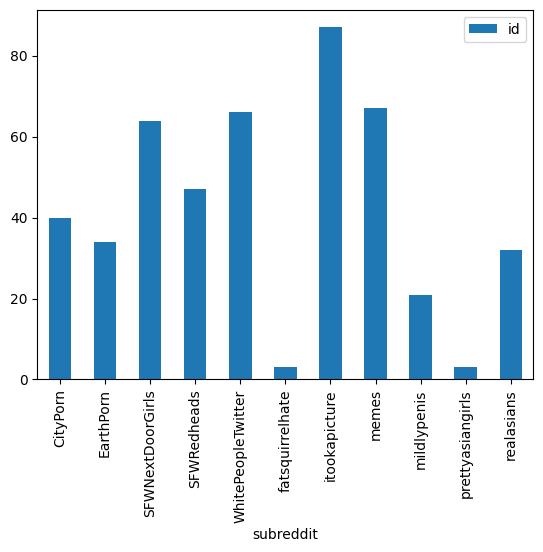

In [20]:
%%time

tqdm.pandas(desc="Filtering Exists For Id List")
with ProgressBar():
	extant = extant_data.where((extant_data['exists'].isin([True]))).dropna(how='all').reset_index().drop('index', axis=1)

extant_id_list = list(extant.id)

tqdm.pandas(desc="Filtering Based on Id")
with ProgressBar():
	new_entries = filtered_initial.where((~filtered_initial['id'].isin(extant_id_list))).dropna(how='all').reset_index().drop('index', axis=1)

display(new_entries)

new_images_by_sub = new_entries.groupby('subreddit')

new_images_by_sub.count().plot.bar(y='id')

In [21]:
%%time

new_entries_1 = new_entries.copy()

tqdm.pandas(desc="Fetch-Image")
with ProgressBar():
	new_entries_1['path'] = new_entries_1.progress_apply(lambda x: fetch_image(x), axis=1)

tqdm.pandas(desc="Get-Image-Name")
with ProgressBar():
	new_entries_1['image_name'] = new_entries_1.progress_apply(lambda x: get_image_name(x), axis=1)

tqdm.pandas(desc="Split-Hash")
with ProgressBar():
	new_entries_1['hash'] = new_entries_1.progress_apply(lambda x: split_hash(x), axis=1)

tqdm.pandas(desc="Checking-Exists")
with ProgressBar():
	new_entries_1['exists'] = new_entries_1.progress_apply(lambda x: exists(x), axis=1)

display(new_entries_1)

Fetch-Image:   0%|          | 0/464 [00:00<?, ?it/s]

cannot identify image file <_io.BytesIO object at 0x000001E980749F40>
cannot write mode RGBA as JPEG


Get-Image-Name:   0%|          | 0/464 [00:00<?, ?it/s]

Split-Hash:   0%|          | 0/464 [00:00<?, ?it/s]

Checking-Exists:   0%|          | 0/464 [00:00<?, ?it/s]

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,12pbl8q,SFWRedheads,officiallyviolets,Finals start today! Wish me luck!,,1730a0c0b95c91bb19abf6511997d37f,/r/SFWRedheads/comments/12pbl8q/finals_start_t...,https://i.redd.it/5030bycyugua1.jpg,1730a0c0b95c91bb19abf6511997d37f.jpg,D:\data\images\SFWRedheads\1730a0c0b95c91bb19a...,,False,False
1,12vaqh1,SFWRedheads,RedheadHeaven,Get on your knees 😈,,faf7b13b55ac15f183e6cd427407c4ed,/r/SFWRedheads/comments/12vaqh1/get_on_your_kn...,https://i.redd.it/2kn2d74t4iva1.jpg,faf7b13b55ac15f183e6cd427407c4ed.jpg,D:\data\images\SFWRedheads\faf7b13b55ac15f183e...,,True,False
2,12vb7af,SFWRedheads,Swim_Pretty,Just your tattooed redhead neighbor,,6bcd35133db6a8686ba1af61c6d80987,/r/SFWRedheads/comments/12vb7af/just_your_tatt...,https://i.redd.it/3by4k3gl7iva1.jpg,6bcd35133db6a8686ba1af61c6d80987.jpg,D:\data\images\SFWRedheads\6bcd35133db6a8686ba...,,True,False
3,12vbxg3,SFWRedheads,bislut997,"So fresh, so clean | Amber Addis",,9e02cd5b4f79ddee50d31166e3f2f8cf,/r/SFWRedheads/comments/12vbxg3/so_fresh_so_cl...,https://i.imgur.com/GJdc00r.jpg,9e02cd5b4f79ddee50d31166e3f2f8cf.jpg,D:\data\images\SFWRedheads\9e02cd5b4f79ddee50d...,,True,False
4,12vc45j,SFWRedheads,missgingerisafox,Venus remix 🐆,,0244419e407a3f46b1427e3bc6fa63af,/r/SFWRedheads/comments/12vc45j/venus_remix/,https://i.redd.it/iwb14gjvciva1.jpg,0244419e407a3f46b1427e3bc6fa63af.jpg,D:\data\images\SFWRedheads\0244419e407a3f46b14...,,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,12w5x14,mildlypenis,Tajjiia,This lamp at my parents house,,5e390b908d4a2d723d8ed41c73cfbfc5,/r/mildlypenis/comments/12w5x14/this_lamp_at_m...,https://i.redd.it/xcvcqcodhmva1.jpg,5e390b908d4a2d723d8ed41c73cfbfc5.jpg,D:\data\images\mildlypenis\5e390b908d4a2d723d8...,,True,False
460,12wchvk,mildlypenis,skrattarforlorar510,these hairs in my shower,,ad08f73639fa5e4444f8521a41fbd858,/r/mildlypenis/comments/12wchvk/these_hairs_in...,https://i.redd.it/t2mekfgyvova1.jpg,ad08f73639fa5e4444f8521a41fbd858.jpg,D:\data\images\mildlypenis\ad08f73639fa5e4444f...,,True,False
461,12wcpqj,mildlypenis,sunspot5b,My husband was calibrating his 3D printer and...,,ce9346bcee854d4b2b17a4c33af085be,/r/mildlypenis/comments/12wcpqj/my_husband_was...,https://i.imgur.com/l6DWUSE.jpg,ce9346bcee854d4b2b17a4c33af085be.jpg,D:\data\images\mildlypenis\ce9346bcee854d4b2b1...,,True,False
462,12webvb,mildlypenis,serenity_later,The inside of my padded bike shorts,,8895550c586de2beca624932eeccfa2a,/r/mildlypenis/comments/12webvb/the_inside_of_...,https://i.imgur.com/RgSARo8.jpg,8895550c586de2beca624932eeccfa2a.jpg,D:\data\images\mildlypenis\8895550c586de2beca6...,,True,False


CPU times: total: 39.6 s
Wall time: 2min 25s


In [22]:
%%time

blip_0 = BlipCaption(1)
blip_1 = BlipCaption(0)

CPU times: total: 33.6 s
Wall time: 30.3 s


In [23]:
%%time

torch.cuda.empty_cache()
new_entries_final = new_entries_1.copy()

tqdm.pandas(desc="Caption-Image")
with ProgressBar():
	new_entries_final['caption'] = new_entries_1.progress_apply(lambda x: caption_image(x, [blip_0, blip_1]), axis=1)
display(new_entries_final)

Caption-Image:   0%|          | 0/464 [00:00<?, ?it/s]

D:\workspaces\General\venv\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,12pbl8q,SFWRedheads,officiallyviolets,Finals start today! Wish me luck!,,1730a0c0b95c91bb19abf6511997d37f,/r/SFWRedheads/comments/12pbl8q/finals_start_t...,https://i.redd.it/5030bycyugua1.jpg,1730a0c0b95c91bb19abf6511997d37f.jpg,D:\data\images\SFWRedheads\1730a0c0b95c91bb19a...,,False,False
1,12vaqh1,SFWRedheads,RedheadHeaven,Get on your knees 😈,arafed woman in lingerie standing in front of ...,faf7b13b55ac15f183e6cd427407c4ed,/r/SFWRedheads/comments/12vaqh1/get_on_your_kn...,https://i.redd.it/2kn2d74t4iva1.jpg,faf7b13b55ac15f183e6cd427407c4ed.jpg,D:\data\images\SFWRedheads\faf7b13b55ac15f183e...,,True,False
2,12vb7af,SFWRedheads,Swim_Pretty,Just your tattooed redhead neighbor,arafed woman with long red hair taking a selfi...,6bcd35133db6a8686ba1af61c6d80987,/r/SFWRedheads/comments/12vb7af/just_your_tatt...,https://i.redd.it/3by4k3gl7iva1.jpg,6bcd35133db6a8686ba1af61c6d80987.jpg,D:\data\images\SFWRedheads\6bcd35133db6a8686ba...,,True,False
3,12vbxg3,SFWRedheads,bislut997,"So fresh, so clean | Amber Addis",arafed woman in a towel brushing her teeth in ...,9e02cd5b4f79ddee50d31166e3f2f8cf,/r/SFWRedheads/comments/12vbxg3/so_fresh_so_cl...,https://i.imgur.com/GJdc00r.jpg,9e02cd5b4f79ddee50d31166e3f2f8cf.jpg,D:\data\images\SFWRedheads\9e02cd5b4f79ddee50d...,,True,False
4,12vc45j,SFWRedheads,missgingerisafox,Venus remix 🐆,woman in a purple bikini drinking a drink on t...,0244419e407a3f46b1427e3bc6fa63af,/r/SFWRedheads/comments/12vc45j/venus_remix/,https://i.redd.it/iwb14gjvciva1.jpg,0244419e407a3f46b1427e3bc6fa63af.jpg,D:\data\images\SFWRedheads\0244419e407a3f46b14...,,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
459,12w5x14,mildlypenis,Tajjiia,This lamp at my parents house,there is a green vase with a lamp on a table,5e390b908d4a2d723d8ed41c73cfbfc5,/r/mildlypenis/comments/12w5x14/this_lamp_at_m...,https://i.redd.it/xcvcqcodhmva1.jpg,5e390b908d4a2d723d8ed41c73cfbfc5.jpg,D:\data\images\mildlypenis\5e390b908d4a2d723d8...,,True,False
460,12wchvk,mildlypenis,skrattarforlorar510,these hairs in my shower,there is a drawing of a hand on a toilet seat,ad08f73639fa5e4444f8521a41fbd858,/r/mildlypenis/comments/12wchvk/these_hairs_in...,https://i.redd.it/t2mekfgyvova1.jpg,ad08f73639fa5e4444f8521a41fbd858.jpg,D:\data\images\mildlypenis\ad08f73639fa5e4444f...,,True,False
461,12wcpqj,mildlypenis,sunspot5b,My husband was calibrating his 3D printer and...,there is a white object with a long string att...,ce9346bcee854d4b2b17a4c33af085be,/r/mildlypenis/comments/12wcpqj/my_husband_was...,https://i.imgur.com/l6DWUSE.jpg,ce9346bcee854d4b2b17a4c33af085be.jpg,D:\data\images\mildlypenis\ce9346bcee854d4b2b1...,,True,False
462,12webvb,mildlypenis,serenity_later,The inside of my padded bike shorts,there is a blue and black object on the floor ...,8895550c586de2beca624932eeccfa2a,/r/mildlypenis/comments/12webvb/the_inside_of_...,https://i.imgur.com/RgSARo8.jpg,8895550c586de2beca624932eeccfa2a.jpg,D:\data\images\mildlypenis\8895550c586de2beca6...,,True,False


CPU times: total: 15min 36s
Wall time: 8min 33s


In [ ]:
# extant_data.set_index('id', inplace=True)
# extant_data.update(new_entries_final.set_index('id'))
# extant_data.reset_index()
#
# display(extant_data)

In [24]:
%%time

tqdm.pandas(desc="Filtering")
writeable_entries = new_entries_final \
	.where(~new_entries_final['id'].isin(extant_data['id'])) \
	.dropna(how='all') \
	.reset_index() \
	.drop('index', axis=1)

display(writeable_entries)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,12vaqh1,SFWRedheads,RedheadHeaven,Get on your knees 😈,arafed woman in lingerie standing in front of ...,faf7b13b55ac15f183e6cd427407c4ed,/r/SFWRedheads/comments/12vaqh1/get_on_your_kn...,https://i.redd.it/2kn2d74t4iva1.jpg,faf7b13b55ac15f183e6cd427407c4ed.jpg,D:\data\images\SFWRedheads\faf7b13b55ac15f183e...,,True,False
1,12vb7af,SFWRedheads,Swim_Pretty,Just your tattooed redhead neighbor,arafed woman with long red hair taking a selfi...,6bcd35133db6a8686ba1af61c6d80987,/r/SFWRedheads/comments/12vb7af/just_your_tatt...,https://i.redd.it/3by4k3gl7iva1.jpg,6bcd35133db6a8686ba1af61c6d80987.jpg,D:\data\images\SFWRedheads\6bcd35133db6a8686ba...,,True,False
2,12vbxg3,SFWRedheads,bislut997,"So fresh, so clean | Amber Addis",arafed woman in a towel brushing her teeth in ...,9e02cd5b4f79ddee50d31166e3f2f8cf,/r/SFWRedheads/comments/12vbxg3/so_fresh_so_cl...,https://i.imgur.com/GJdc00r.jpg,9e02cd5b4f79ddee50d31166e3f2f8cf.jpg,D:\data\images\SFWRedheads\9e02cd5b4f79ddee50d...,,True,False
3,12vc45j,SFWRedheads,missgingerisafox,Venus remix 🐆,woman in a purple bikini drinking a drink on t...,0244419e407a3f46b1427e3bc6fa63af,/r/SFWRedheads/comments/12vc45j/venus_remix/,https://i.redd.it/iwb14gjvciva1.jpg,0244419e407a3f46b1427e3bc6fa63af.jpg,D:\data\images\SFWRedheads\0244419e407a3f46b14...,,True,False
4,12vc77j,SFWRedheads,nurselacey,💋,there is a woman with long hair and gloves on ...,0ca7f9778bb6c20ea4a009d52a11b2c9,/r/SFWRedheads/comments/12vc77j/_/,https://i.redd.it/8s2drd2ddiva1.jpg,0ca7f9778bb6c20ea4a009d52a11b2c9.jpg,D:\data\images\SFWRedheads\0ca7f9778bb6c20ea4a...,,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,12w5x14,mildlypenis,Tajjiia,This lamp at my parents house,there is a green vase with a lamp on a table,5e390b908d4a2d723d8ed41c73cfbfc5,/r/mildlypenis/comments/12w5x14/this_lamp_at_m...,https://i.redd.it/xcvcqcodhmva1.jpg,5e390b908d4a2d723d8ed41c73cfbfc5.jpg,D:\data\images\mildlypenis\5e390b908d4a2d723d8...,,True,False
455,12wchvk,mildlypenis,skrattarforlorar510,these hairs in my shower,there is a drawing of a hand on a toilet seat,ad08f73639fa5e4444f8521a41fbd858,/r/mildlypenis/comments/12wchvk/these_hairs_in...,https://i.redd.it/t2mekfgyvova1.jpg,ad08f73639fa5e4444f8521a41fbd858.jpg,D:\data\images\mildlypenis\ad08f73639fa5e4444f...,,True,False
456,12wcpqj,mildlypenis,sunspot5b,My husband was calibrating his 3D printer and...,there is a white object with a long string att...,ce9346bcee854d4b2b17a4c33af085be,/r/mildlypenis/comments/12wcpqj/my_husband_was...,https://i.imgur.com/l6DWUSE.jpg,ce9346bcee854d4b2b17a4c33af085be.jpg,D:\data\images\mildlypenis\ce9346bcee854d4b2b1...,,True,False
457,12webvb,mildlypenis,serenity_later,The inside of my padded bike shorts,there is a blue and black object on the floor ...,8895550c586de2beca624932eeccfa2a,/r/mildlypenis/comments/12webvb/the_inside_of_...,https://i.imgur.com/RgSARo8.jpg,8895550c586de2beca624932eeccfa2a.jpg,D:\data\images\mildlypenis\8895550c586de2beca6...,,True,False


CPU times: total: 0 ns
Wall time: 6.32 ms


In [25]:
%%time

combined_result = pd.concat([extant_data, writeable_entries])

display(combined_result)

<timed exec>:1: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.


,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,128z5ns,celebrities,A-Sexy-Name,Rachel Weisz,cars are parked on the side of the road in the...,f09b1c0c5dea50c934081a04c83d4d33,/r/celebrities/comments/128z5ns/rachel_weisz/,https://i.redd.it/nv80afddacra1.jpg,f09b1c0c5dea50c934081a04c83d4d33.jpg,D:\data\images\celebrities\f09b1c0c5dea50c9340...,D:\data\images\celebrities\thumbnail\f09b1c0c5...,True,False
1,11yk8db,prettyasiangirls,MisoShiru520,Library,blonde woman with blonde hair and tattoos on h...,9d5b7331b941ecf3fdbc8ad322303825,/r/prettyasiangirls/comments/11yk8db/library/,https://i.redd.it/ht4d2wuusapa1.jpg,9d5b7331b941ecf3fdbc8ad322303825.jpg,D:\data\images\prettyasiangirls\9d5b7331b941ec...,D:\data\images\prettyasiangirls\thumbnail\9d5b...,True,False
2,11hfioi,KoreanHotties,Majestic_Painter8660,Underboob bikini,a man with a beard and a beard sitting in fron...,a154a56b1b87cf3a0bc93600c86e4585,/r/KoreanHotties/comments/11hfioi/underboob_bi...,https://i.redd.it/cimr17q84jla1.jpg,a154a56b1b87cf3a0bc93600c86e4585.jpg,D:\ImageDoesNotExist.png,D:\data\images\KoreanHotties\thumbnail\a154a56...,False,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,D:\data\images\spaceporn\7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,D:\data\images\spaceporn\abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,12w5x14,mildlypenis,Tajjiia,This lamp at my parents house,there is a green vase with a lamp on a table,5e390b908d4a2d723d8ed41c73cfbfc5,/r/mildlypenis/comments/12w5x14/this_lamp_at_m...,https://i.redd.it/xcvcqcodhmva1.jpg,5e390b908d4a2d723d8ed41c73cfbfc5.jpg,D:\data\images\mildlypenis\5e390b908d4a2d723d8...,,True,False
455,12wchvk,mildlypenis,skrattarforlorar510,these hairs in my shower,there is a drawing of a hand on a toilet seat,ad08f73639fa5e4444f8521a41fbd858,/r/mildlypenis/comments/12wchvk/these_hairs_in...,https://i.redd.it/t2mekfgyvova1.jpg,ad08f73639fa5e4444f8521a41fbd858.jpg,D:\data\images\mildlypenis\ad08f73639fa5e4444f...,,True,False
456,12wcpqj,mildlypenis,sunspot5b,My husband was calibrating his 3D printer and...,there is a white object with a long string att...,ce9346bcee854d4b2b17a4c33af085be,/r/mildlypenis/comments/12wcpqj/my_husband_was...,https://i.imgur.com/l6DWUSE.jpg,ce9346bcee854d4b2b17a4c33af085be.jpg,D:\data\images\mildlypenis\ce9346bcee854d4b2b1...,,True,False
457,12webvb,mildlypenis,serenity_later,The inside of my padded bike shorts,there is a blue and black object on the floor ...,8895550c586de2beca624932eeccfa2a,/r/mildlypenis/comments/12webvb/the_inside_of_...,https://i.imgur.com/RgSARo8.jpg,8895550c586de2beca624932eeccfa2a.jpg,D:\data\images\mildlypenis\8895550c586de2beca6...,,True,False


CPU times: total: 31.2 ms
Wall time: 15 ms


In [26]:
%%time

combined_result.reindex()
combined_result.to_csv('processed_raw_data.csv', index=False)
f = AzureFileStorageAdapter('data').get_file_storage()
f.put('processed_raw_data.csv', 'data/processed_raw_data.csv', overwrite=True)

CPU times: total: 625 ms
Wall time: 5.76 s


[None]

In [27]:
%%time

final = pd.read_csv(f.open('data/processed_raw_data.csv'))
final.to_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system, schema=schema)

CPU times: total: 641 ms
Wall time: 4.51 s


In [28]:
%%time

final = pd.read_parquet("data/processed_raw_data.parquet", engine='pyarrow', filesystem=file_system)
display(final)

,id,subreddit,author,title,caption,hash,permalink,original_url,image_name,path,thumbnail_path,exists,curated
0,128z5ns,celebrities,A-Sexy-Name,Rachel Weisz,cars are parked on the side of the road in the...,f09b1c0c5dea50c934081a04c83d4d33,/r/celebrities/comments/128z5ns/rachel_weisz/,https://i.redd.it/nv80afddacra1.jpg,f09b1c0c5dea50c934081a04c83d4d33.jpg,D:\data\images\celebrities\f09b1c0c5dea50c9340...,D:\data\images\celebrities\thumbnail\f09b1c0c5...,True,False
1,11yk8db,prettyasiangirls,MisoShiru520,Library,blonde woman with blonde hair and tattoos on h...,9d5b7331b941ecf3fdbc8ad322303825,/r/prettyasiangirls/comments/11yk8db/library/,https://i.redd.it/ht4d2wuusapa1.jpg,9d5b7331b941ecf3fdbc8ad322303825.jpg,D:\data\images\prettyasiangirls\9d5b7331b941ec...,D:\data\images\prettyasiangirls\thumbnail\9d5b...,True,False
2,11hfioi,KoreanHotties,Majestic_Painter8660,Underboob bikini,a man with a beard and a beard sitting in fron...,a154a56b1b87cf3a0bc93600c86e4585,/r/KoreanHotties/comments/11hfioi/underboob_bi...,https://i.redd.it/cimr17q84jla1.jpg,a154a56b1b87cf3a0bc93600c86e4585.jpg,D:\ImageDoesNotExist.png,D:\data\images\KoreanHotties\thumbnail\a154a56...,False,False
3,1000mjs,spaceporn,MorningStar_imangi,Northern Lights above Lofoten,a view of a view of a large green and purple a...,2c39ce1290fba541abd0b004b09da6b2,/r/spaceporn/comments/1000mjs/northern_lights_...,https://i.redd.it/7s5aafaqkb9a1.jpg,7s5aafaqkb9a1.jpg,D:\data\images\spaceporn\7s5aafaqkb9a1.jpg,/data/images/spaceporn/thumbnail/7s5aafaqkb9a1...,True,False
4,1000qpd,spaceporn,MorningStar_imangi,Viking Lights,a scene of a boat is sitting on the shore of a...,0f72de47c69ff50eca5fa3990215f4ac,/r/spaceporn/comments/1000qpd/viking_lights/,https://i.redd.it/abojw7lqlb9a1.jpg,abojw7lqlb9a1.jpg,D:\data\images\spaceporn\abojw7lqlb9a1.jpg,/data/images/spaceporn/thumbnail/abojw7lqlb9a1...,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32546,12w5x14,mildlypenis,Tajjiia,This lamp at my parents house,there is a green vase with a lamp on a table,5e390b908d4a2d723d8ed41c73cfbfc5,/r/mildlypenis/comments/12w5x14/this_lamp_at_m...,https://i.redd.it/xcvcqcodhmva1.jpg,5e390b908d4a2d723d8ed41c73cfbfc5.jpg,D:\data\images\mildlypenis\5e390b908d4a2d723d8...,None,True,False
32547,12wchvk,mildlypenis,skrattarforlorar510,these hairs in my shower,there is a drawing of a hand on a toilet seat,ad08f73639fa5e4444f8521a41fbd858,/r/mildlypenis/comments/12wchvk/these_hairs_in...,https://i.redd.it/t2mekfgyvova1.jpg,ad08f73639fa5e4444f8521a41fbd858.jpg,D:\data\images\mildlypenis\ad08f73639fa5e4444f...,None,True,False
32548,12wcpqj,mildlypenis,sunspot5b,My husband was calibrating his 3D printer and...,there is a white object with a long string att...,ce9346bcee854d4b2b17a4c33af085be,/r/mildlypenis/comments/12wcpqj/my_husband_was...,https://i.imgur.com/l6DWUSE.jpg,ce9346bcee854d4b2b17a4c33af085be.jpg,D:\data\images\mildlypenis\ce9346bcee854d4b2b1...,None,True,False
32549,12webvb,mildlypenis,serenity_later,The inside of my padded bike shorts,there is a blue and black object on the floor ...,8895550c586de2beca624932eeccfa2a,/r/mildlypenis/comments/12webvb/the_inside_of_...,https://i.imgur.com/RgSARo8.jpg,8895550c586de2beca624932eeccfa2a.jpg,D:\data\images\mildlypenis\8895550c586de2beca6...,None,True,False


CPU times: total: 250 ms
Wall time: 735 ms
